<div><span style="background-color: #9e4244; padding-top: 80px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: white; font-size: 22px; font-weight: bold">Session 5: Going Past Accuracy</span></div>

by BYJ Cirio

<div class="alert alert-danger alert-info">
     In this notebook you will learn different evaluation metrics beside accuracy. Specifically, the topics covered are as follows:<br>
    <ol>
        <li>Stratify and StratifiedKFold</li>
        <li>Other Evaluation Metrics: Precision, Recall, F1-Score</li>
        <li><i>Exercise: Re-run models using Precision, Recall, F1-Score</i></li>
    </ol>
</div>

In [1]:
# general libraries
import time
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

# modelling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
df = pd.read_csv('cc_df.csv', nrows=100000)
df.head()

,lat,long,city_pop,amt,is_fraud,merch_lat,merch_long,trans_day,age,gender_F,...,trans_month__Mar,trans_month__May,trans_month__Nov,trans_month__Oct,trans_month__Sep,part_of_day_afternoon,part_of_day_breakfast,part_of_day_dinner,part_of_day_early morning,part_of_day_lunch
0,9.65,123.85,105051,825.04,1,9.265518,123.368859,13,60,0,...,0,0,0,0,0,0,0,1,0,0
1,9.65,123.85,105051,306.55,1,9.236416,124.337292,12,60,0,...,0,0,0,0,0,0,0,0,1,0
2,9.65,123.85,105051,346.48,1,9.460644,124.461767,12,60,0,...,0,0,0,0,0,0,0,0,0,1
3,9.65,123.85,105051,919.50,1,10.606020,123.930862,12,60,0,...,0,0,0,0,0,0,0,0,1,0
4,9.65,123.85,105051,1131.45,1,8.806183,123.719528,13,60,0,...,0,0,0,0,0,0,0,1,0,0


Would Recommend:       0
1    924
0  99076
Proportion Chance Criterion: 98.17%
1.25 * Proportion Chance Criterion: 122.71%


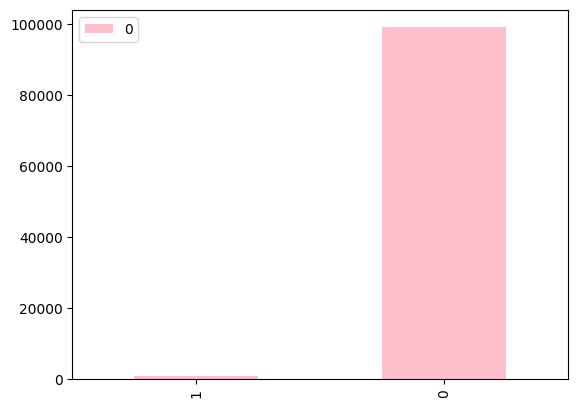

In [3]:
state_counts = Counter(df['is_fraud'])
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
df_state.plot(kind='bar', color='pink')

num=(df_state[0]/df_state[0].sum())**2

print("Would Recommend:{}".format(df_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Stratify/StratifiedKFold </span></div>

In [4]:
X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                                  random_state=11, test_size=0.25,
                                                                  stratify=y) # to maintain the number of samples for each class

We use [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) to split the train set further into train and validation sets. This is done to address overfitting and ensure same numbers are maintained for each class.

In [5]:
# initialize models with default hyperparamters
models_dict = {
    'LogisticRegressor': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(random_state=11),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=11),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=11)   
}

In [6]:
# budget automl
skf = StratifiedKFold(n_splits=5)

res = {}

# log start time
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    train_scores = []
    val_scores = []
    
    for train_index, val_index in skf.split(X_trainval, y_trainval): # train and validation set
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        
        start_time = time.time() # for logging run times
        
        # fit
        model.fit(X_train, y_train)
        
        # default metric: accuracy
        train_score = model.score(X_train, y_train)
        val_score = model.score(X_val, y_val)
        
        end_time = time.time() # for logging run times
        
        train_scores.append(train_score)
        val_scores.append(val_score)
        
    res[model_name] = {
        'ave_train_acc':np.mean(train_scores) * 100,
        'ave_val_acc':np.mean(val_scores) * 100,
        'run_time': end_time - start_time
    }

# log end time
total_end = time.time()

elapsed = total_end - total_start
print(f"Report Generated in {elapsed:.2f} seconds")
display(pd.DataFrame(res).T)

  0%|          | 0/4 [00:00<?, ?it/s]

Report Generated in 372.61 seconds


,ave_train_acc,ave_val_acc,run_time
LogisticRegressor,98.938667,98.938667,3.710219
RandomForestClassifier,100.000000,99.617333,18.186849
DecisionTreeClassifier,100.000000,99.728000,4.829628
GradientBoostingClassifier,99.888667,99.766667,45.623910


The current results show that our ML models perform well. But do they really? Being the the skeptics that we are, we go *beyond accuracy* and look deeper into the predictions in the following sections. 

In [7]:
def get_confusion_matrix(y_true, y_pred, return_tuple=False):
    """Return confusion matrix from inputs of true and predicted values"""
    TP = ((y_pred == 1) & (y_true == 1)).sum()
    TN = ((y_pred == 0) & (y_true == 0)).sum()
    FP = ((y_pred == 1) & (y_true == 0)).sum()
    FN = ((y_pred == 0) & (y_true == 1)).sum()
    if return_tuple:
        return TN, FP, FN, TP
    return np.array([[TN, FP],
                     [FN, TP]])

In [8]:
# Show counting of TP, TN, FP, FN
model = GradientBoostingClassifier()
model.fit(X_trainval, y_trainval)

y_pred = model.predict(X_holdout)
y_true = y_holdout

get_confusion_matrix(y_true, y_pred)

array([[24736,    33],
       [   45,   186]], dtype=int64)

0it [00:00, ?it/s]

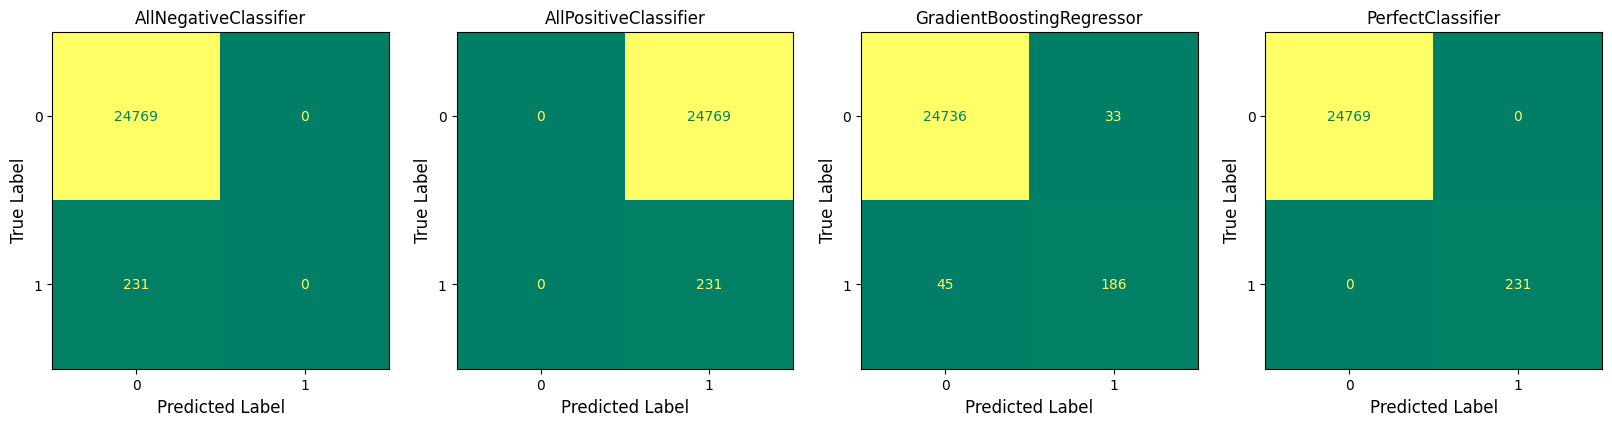

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

best_model = GradientBoostingClassifier()
best_model.fit(X_trainval, y_trainval)
y_pred = model.predict(X_holdout)

eval_dict = {
    'AllNegativeClassifier': np.zeros(y_holdout.shape),
    'AllPositiveClassifier' : np.ones(y_holdout.shape),
    'GradientBoostingRegressor': y_pred,
    'PerfectClassifier': y_holdout
}

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for index, (model_name, preds) in tqdm(enumerate(eval_dict.items())):
    ConfusionMatrixDisplay.from_predictions(y_holdout, preds, 
                                            ax=axes[index], cmap='summer',
                                            colorbar=False)
    axes[index].set_title(model_name, fontsize=12)
    axes[index].set_xlabel('Predicted Label', fontsize=12)
    axes[index].set_ylabel('True Label', fontsize=12)

In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(y_holdout, np.zeros(y_holdout.shape))

0.99076

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Other Evaluation Metrics </span></div>

* ***Recall***  - Tells how well the positive (minority) class was predicted

\begin{equation}
\mathrm{Recall} = \frac{TP}{TP + FN}
\end{equation}

* ***Precision*** - Measures the fraction of correctly classified positive class and the number of samples classified as positive

\begin{equation}
\mathrm{Precision} = \frac{TP}{TP + FP}
\end{equation}


* ***F-1 score*** - Captures the harmonic balance between precision and recall

\begin{equation}
\mathrm{F1}  = 2*\frac{\mathrm{Precision}*\mathrm{Recall}}{\mathrm{Precision} + \mathrm{Recall}}
\end{equation}

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Exercise </span></div>

1) Add codes to incorporate `precision`, `recall`, and `F1-score`. Based on the business objective of the study, which metric is the most appropriate? <br>
2) Can you think of ways on how you can further hypertune the parameters for a specific model?

In [11]:
from sklearn.metrics import (precision_score, recall_score, f1_score)

In [14]:
# budget automl
skf = StratifiedKFold(n_splits=5)

res = {}

# log start time
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    train_scores = []
    val_scores = []
    
    #### (1) Insert containers here for the precision, recall, and f1 score ####

    
    ####--------------------------------------------------------- ####
    
    for train_index, val_index in tqdm(skf.split(X_trainval, y_trainval)): # train and validation set
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        
        start_time = time.time() # for logging run times
        
        # fit
        model.fit(X_train, y_train)
        
        # default metric: accuracy
        train_score = model.score(X_train, y_train)
        val_score = model.score(X_val, y_val)
        
        end_time = time.time() # for logging run times
        
        train_scores.append(train_score)
        val_scores.append(val_score)
        
        #### (2) Predict the train and validation sets####
        
        # predict
        
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        
        ####----------------------------------------- ####
        
        #### (3) Compute and append the precision, recall, and f1 score to its containers ####
        
        # precision
        
        start_time = time.time() # for logging run times
        
        # default metric: accuracy
        train_prec = precision_score(y_train, y_pred_train)
        val_prec = precision_score(y_val, y_pred_val)
        
        end_time = time.time() # for logging run times
        
        train_scores.append(train_prec)
        val_scores.append(val_prec)

        # recall
        
        start_time = time.time() # for logging run times
        
        # default metric: accuracy
        train_rec = recall_score(y_train, y_pred_train)
        val_rec = recall_score(y_val, y_pred_val)
        
        end_time = time.time() # for logging run times
        
        train_scores.append(train_rec)
        val_scores.append(val_rec)
        
        
        # f1
        
        start_time = time.time() # for logging run times
        
        # default metric: accuracy
        train_f1 = f1_score(y_train, y_pred_train)
        val_f1 = f1_score(y_val, y_pred_val)
        
        end_time = time.time() # for logging run times
        
        train_scores.append(train_f1)
        val_scores.append(val_f1)
        
        
        ####------------------------------------------------------------------------- ####
        
    res[model_name] = {
        'ave_train_acc':np.mean(train_scores) * 100,
        'ave_val_acc':np.mean(val_scores) * 100,
        'ave_train_prec':np.mean(train_prec) * 100,
        'ave_val_prec':np.mean(val_prec) * 100,
        'ave_train_rec':np.mean(train_rec) * 100,
        'ave_val_rec':np.mean(val_rec) * 100,
        'ave_train_f1':np.mean(train_f1) * 100,
        'ave_val_f1':np.mean(val_f1) * 100,
        'run_time': end_time - start_time
    }

# log end time
total_end = time.time()

elapsed = total_end - total_start
print(f"Report Generated in {elapsed:.2f} seconds")
display(pd.DataFrame(res).T)

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Report Generated in 381.20 seconds


,ave_train_acc,ave_val_acc,ave_train_prec,ave_val_prec,ave_train_rec,ave_val_rec,ave_train_f1,ave_val_f1,run_time
LogisticRegressor,25.398865,25.389825,1.176471,5.000000,0.180505,0.719424,0.312989,1.257862,0.011500
RandomForestClassifier,100.000000,83.004090,100.000000,100.000000,100.000000,56.115108,100.000000,71.889401,0.011938
DecisionTreeClassifier,100.000000,88.668668,100.000000,88.970588,100.000000,87.050360,100.000000,88.000000,0.020016
GradientBoostingClassifier,95.379056,90.145478,94.318182,88.970588,89.891697,87.050360,92.051756,88.000000,0.011997
